### Use IOT data to create a 'safe driver index' which can be used for insurance company rewards. 

In [ ]:
BUCKET = 'hackathon-ALSET'
PROJECT = 'hackathon-ALSET'

import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT

In [21]:
# Copy files from google storage
%bash
INPUT=gs://${BUCKET}/Datathon_Final_Data_V1.1%2FDatathon_IOT_Data.csv
gsutil cp $INPUT Datathon_Final_Data_V1.1%2FDatathon_IOT_Data.csv

Copying gs://datathon-team19-19/Datathon_Final_Data_V1.1%2FDatathon_IOT_Data.csv...
- [1 files][ 28.1 MiB/ 28.1 MiB]                                                
Operation completed over 1 objects/28.1 MiB.                                     


In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib as mp
import scipy as sp
import csv
import math as math
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, timedelta, time
from time import sleep
from dateutil.parser import parse
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler


# read IOT dataset into pandas
df = pd.read_csv("Datathon_Final_Data_V1.1%2FDatathon_IOT_Data.csv",index_col=False)

### An indicator was created to address dangerous instances:
Type column only has integer 18 and below

In [23]:
# Dangerous instances
df['Dangerous'] =0
df.loc[(df.Type == 3) | (df.Type == 6) | (df.Type == 6)| (df.Type == 7)| (df.Type == 8)| (df.Type == 9) | (df.Type == 10)| (df.Type == 12) | (df.Type == 16), 'Dangerous'] = 1  
#3 Overspeed Alarm
#6 Fatigue Alarm
#7 Emergency Acceleration Alarm
#8 Emergency Deceleration Alarm
#9 Sharp Turn Alarm
#10 Collision Alarm
#12 High Speed Alarm
#16 Pull Out Alarm
df=df.rename(columns={'Locate time': "time"})
df = df.set_index(pd.DatetimeIndex(df['time']))
# Drop unwanted columns
df = df.drop(['Device PN','time', 'Type', 'Locate Status', 'Engine Status', 'Total Line Status', 'Trip Status', 'Mileage Source', 'GPS Sensor', 'Gravity'], axis=1)
# mark all NA values with 0
columns_names=list(df.columns)
for names in columns_names:
    df[names].fillna(0, inplace=True)
columns_names=cols = columns_names[-1:] + columns_names[:-1]
# rearrange the dangerous indicator columns to first column
df = df[columns_names]

In [24]:
df.head()

,Dangerous,Altitude,GPS Speed,Speedometer,Torque,Voltage,Average Speed,Fuel Consumption,Interval time,Interval fuel,Longitude,Latitude,Direction,Temp
time,,,,,,,,,,,,,,
2018-07-23 01:50:00,0,-50,0.9,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00000,0.00000,0,0.0
2018-07-23 02:21:00,0,-50,0.6,0.0,0.0,13.09,0.2,0.0,0.0,0.0,0.00000,0.00000,0,0.0
2018-07-23 02:22:00,1,-35,7.1,0.0,0.0,0.00,0.0,0.0,0.0,0.0,101.58200,2.93670,338,0.0
2018-07-23 02:22:00,0,-39,56.3,0.0,0.0,13.43,0.0,0.0,326.0,0.0,101.58198,2.93895,64,0.0
2018-07-23 02:22:00,0,-39,56.9,0.0,0.0,0.00,0.0,0.0,0.0,0.0,101.58254,2.93878,63,0.0


### Try to have a glance of the data

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


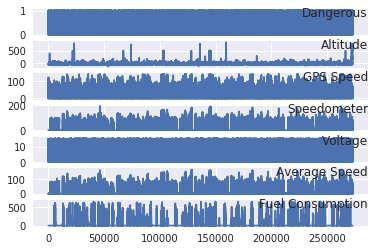

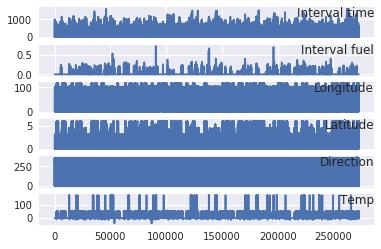

In [25]:
values = df.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(df.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()


groups = [8,9,10,11,12,13]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(df.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

### We are going to do a multivariate-time-series-forecasting using LSTM where older timepoints are not that relevant in comparison to the newer timepoints. When the model is deployed, model can be run in real time where every new second a driver will have a new driver safety index and and the model can predict dangerous situation depending on the sensor inputs at previous time points. Here we use t-3, t-2,t-1 datapoints as inputs. The chosing of t-3, t-2,t-1 datapoints might not be optimal, but we believe it is good enough to start testing

In [26]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
# ensure all data is float
values = df.values
values = values.astype('float32')
#print(values[0])


# specify the number of lag time steps
n_time = 3
n_features = 13
# frame as supervised learning
reframed = series_to_supervised(df, n_time, 1)

# Drop the dangerous indicator at t-3, t-2, t-1 data points columns
reframed_new=pd.concat([reframed.iloc[:,1:14], reframed.iloc[:,15:28], reframed.iloc[:,29:42],  reframed.iloc[:,42]], axis=1)

In [27]:
# normalize features
values = reframed_new.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled= pd.DataFrame(scaled)
X=scaled.iloc[:,0:-1]
y=scaled.iloc[:,-1]
X=np.array(X)
y=np.array(y)


In [28]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [29]:
# reshape input to be 3D [samples, timesteps, features] 
X_train = X_train.reshape((X_train.shape[0], n_time, 13))
X_test = X_test.reshape((X_test.shape[0], n_time, 13))


In [30]:
!pip install keras

In [31]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [32]:
import time
start = time.time()
# Tuning the RNN
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV,KFold
from sklearn.model_selection import cross_val_score
def build_classifier(neurons=50,dropout_rate=0.2, optimizer='adam', activation='relu'):
    classifier = Sequential()
    # Adding the first LSTM layer and some Dropout regularisation
    classifier.add(LSTM(units = neurons, return_sequences = True, activation=activation, input_shape = (X_train.shape[1], X_train.shape[2])))
    classifier.add(Dropout(dropout_rate))
    # Adding a second LSTM layer and some Dropout regularisation
    classifier.add(LSTM(units = neurons, return_sequences = True, activation=activation))
    classifier.add(Dropout(dropout_rate))
    # Adding a third LSTM layer and some Dropout regularisation
    classifier.add(LSTM(units = neurons, return_sequences = True, activation=activation))
    classifier.add(Dropout(dropout_rate))
    # Adding a fourth LSTM layer and some Dropout regularisation
    classifier.add(LSTM(units = neurons))
    classifier.add(Dropout(dropout_rate))
    # Adding the output layer
    classifier.add(Dense(units = 1, activation = 'sigmoid'))
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier


classifier = KerasClassifier(build_fn = build_classifier)

#parameters = {'batch_size' : [20, 40, 60],
#                'epochs' : [50, 100],
#                'optimizer' : ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
#               'activation' : ['softmax', 'softplus', 'softsign', 'relu', 'tanh'],
#              'dropout_rate' : [0.1, 0.2, 0.3],
#                'neurons' : [15, 30, 50]}

#The pareameters are harcoded because we could not make grid search work in Google Cloud, leave the code above commented

parameters = {'batch_size' : [50],
                'epochs' : [2],
                'optimizer' : ['SGD'],
              'activation' : ['softmax'],
               'dropout_rate' : [0.1],
                'neurons' : [50]}
grid_search = RandomizedSearchCV(estimator = classifier,
                          param_distributions = parameters,
                           n_iter=1,
                           n_jobs=1,
                           scoring = 'accuracy',
                           cv = 3)

grid_search = grid_search.fit(X_train, y_train)
end = time.time()
print((end - start)/60)
print("Best accuracy: %f using %s" % (grid_search.best_score_, grid_search.best_params_))

Epoch 1/2
145483/145483 [==============================] - 71s 489us/step - loss: 0.1635 - acc: 0.9740
Epoch 2/2
145483/145483 [==============================] - 67s 459us/step - loss: 0.1203 - acc: 0.9741
Epoch 1/2
145483/145483 [==============================] - 73s 501us/step - loss: 0.1626 - acc: 0.9741
Epoch 2/2
145483/145483 [==============================] - 67s 461us/step - loss: 0.1204 - acc: 0.9741
Epoch 1/2
145484/145484 [==============================] - 71s 491us/step - loss: 0.1659 - acc: 0.9734
Epoch 2/2
145484/145484 [==============================] - 67s 461us/step - loss: 0.1207 - acc: 0.9740
Epoch 1/2
218225/218225 [==============================] - 105s 482us/step - loss: 0.1496 - acc: 0.9741
Epoch 2/2
218225/218225 [==============================] - 101s 463us/step - loss: 0.1204 - acc: 0.9741
12.215461389223735
Best accuracy: 0.974091 using {'neurons': 50, 'batch_size': 50, 'epochs': 2, 'dropout_rate': 0.1, 'activation': 'softmax', 'optimizer': 'SGD'}


In [33]:
best_random = grid_search.best_estimator_
# Probability of dangerous instances occuring on test set
predicted_probability = best_random.predict(X_test)

In [34]:
y_pred = (predicted_probability > 0.5)
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [49]:
print("Accuracy: ", (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1]))

Accuracy:  0.973697234085452
